In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,precision_score, recall_score
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# DOWNLOADING DATA

#### Data is about credit score and it is taken from Kaggle Datasets

In [205]:
df= pd.read_csv('full_data.csv')

In [206]:
df.shape

(22432, 29)

## Data Preprocessing and Analysing

In [207]:

def quick_preprocessing(data):
    data = data.drop(columns = ['Unnamed: 0','Type_of_Loan', 'Payment_Behaviour','ID', 'Age','SSN','Customer_ID', 'Occupation','Name', 'Month'], axis = 1)
    data['Credit_Score'] = data['Credit_Score'].replace({"Poor": 0, "Good": 1, "Standard":2})
    return data


In [208]:
df = quick_preprocessing(df)

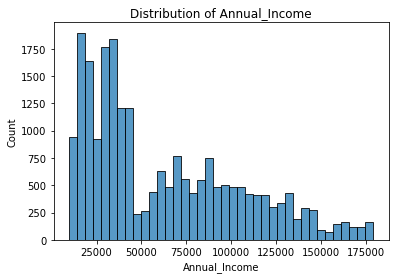

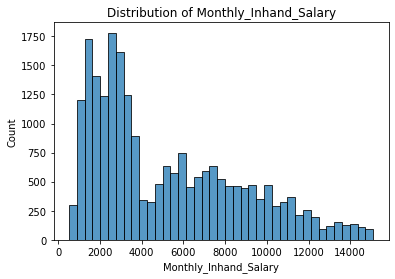

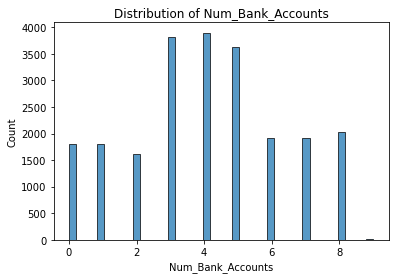

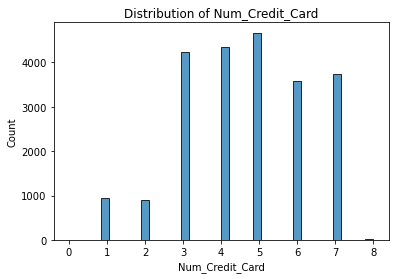

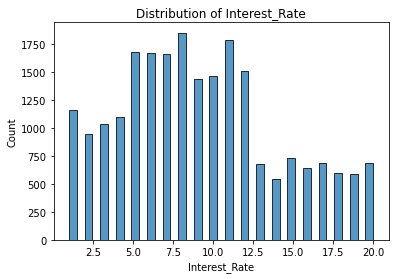

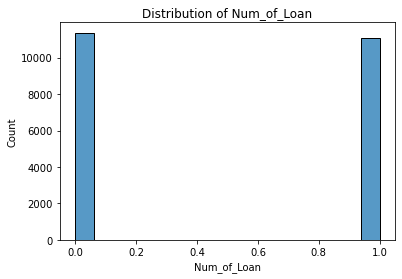

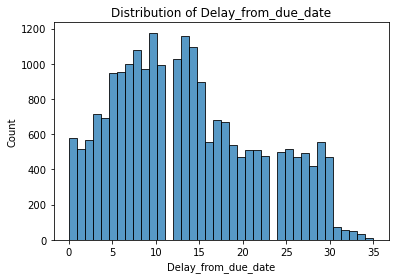

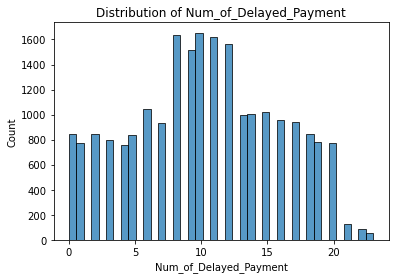

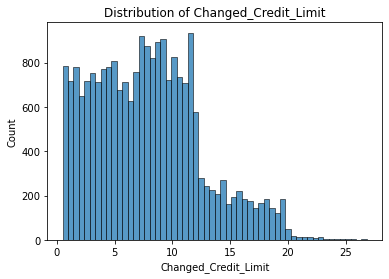

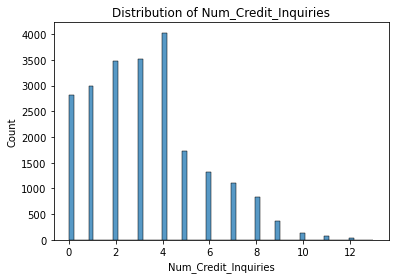

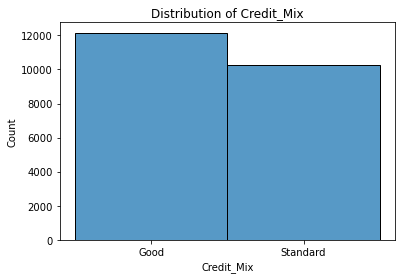

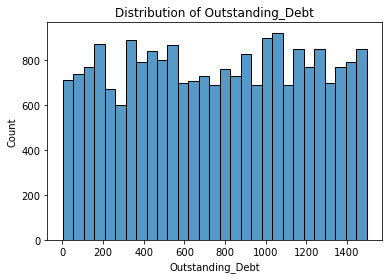

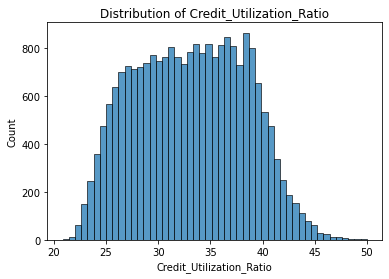

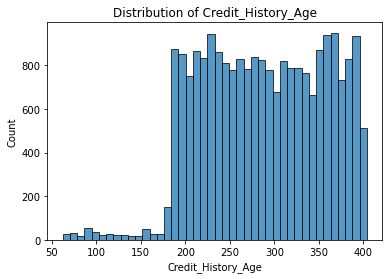

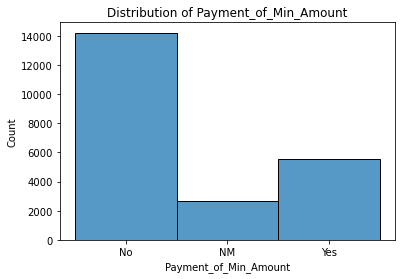

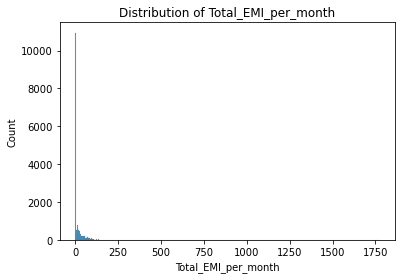

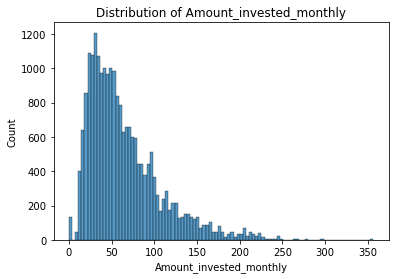

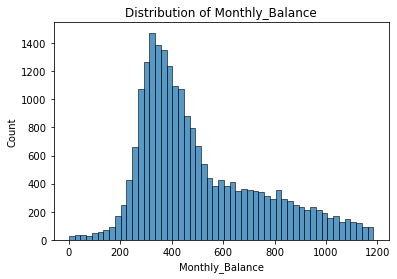

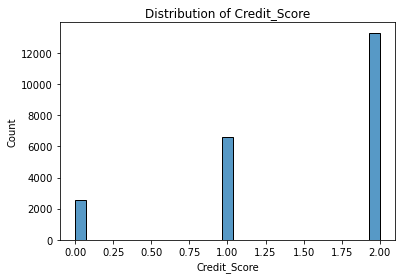

In [209]:
for column in df.columns:
    plt.figure()
    sns.histplot(data=df[column])
    plt.title(f"Distribution of {column}")
    plt.show()

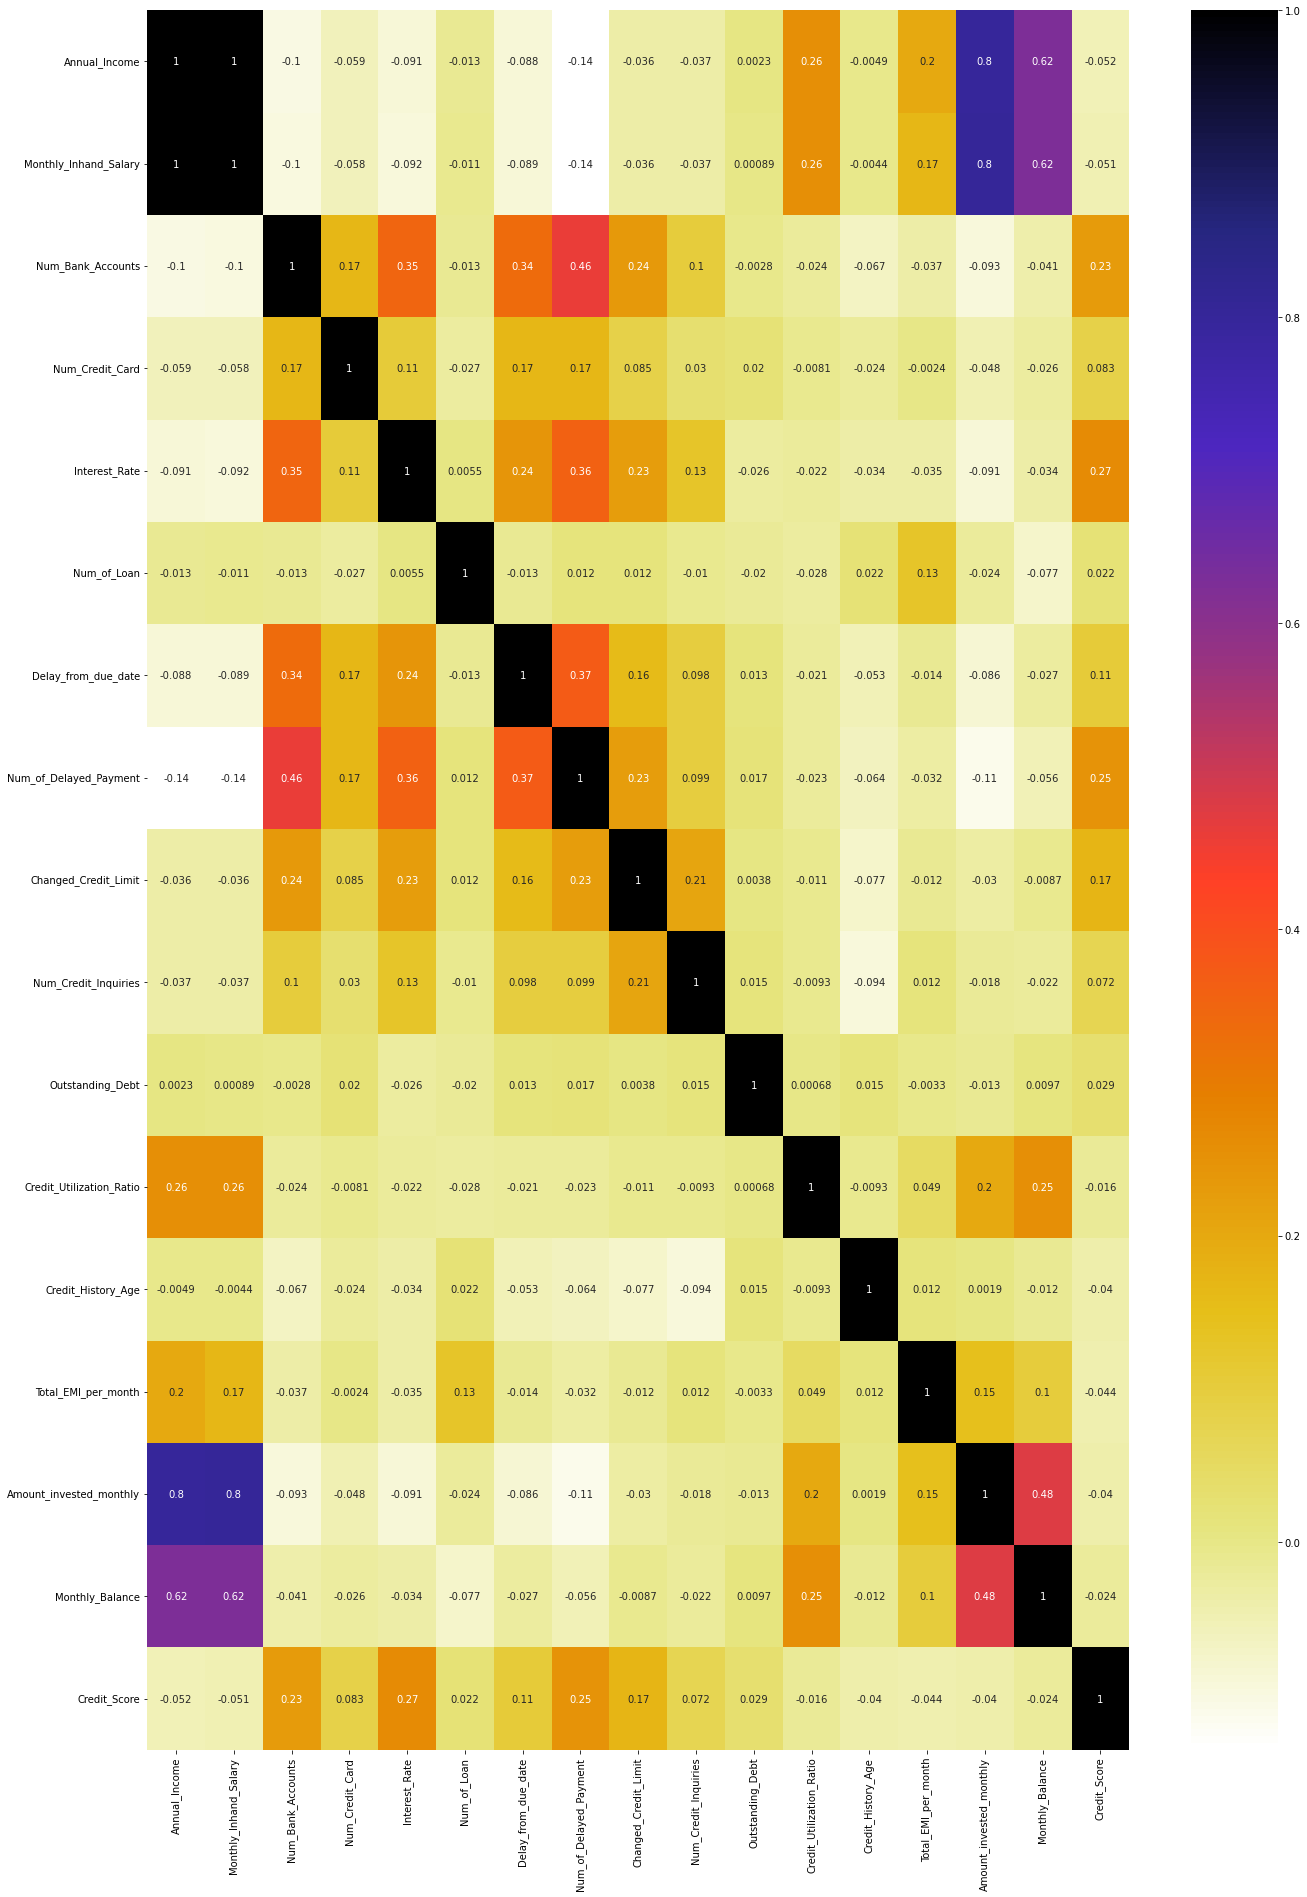

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt
#Using Pearson Correlation
plt.figure(figsize=(22,32))
cor = df.select_dtypes(exclude = 'object').corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

#### As you see from correlation matrix, there are not many correlated columns in data  

# Split into Training, Validation and Test Sets

In [211]:
X = df.drop('Credit_Score', axis=1) 
y = df['Credit_Score']

In [212]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.12, random_state=42)

In [213]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [214]:
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (19740, 18)
Validation set shape: (1346, 18)
Test set shape: (1346, 18)


# Feature Engineering

#### First of all, we would like not to select zero variance columns

In [215]:
X_train_num=X_train.select_dtypes(exclude = 'object')
X_val_num = X_val.select_dtypes(exclude = 'object')

In [216]:
X_train_obj=X_train.select_dtypes(include = 'object')
X_val_obj = X_val.select_dtypes(include = 'object')

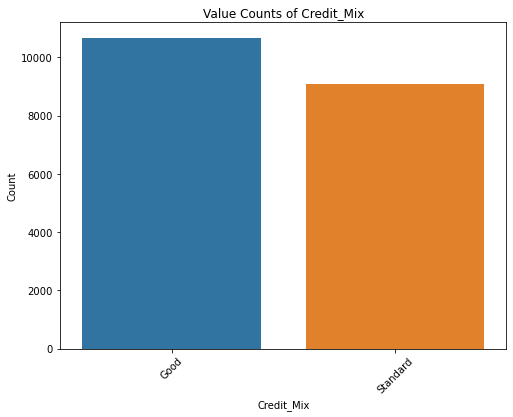

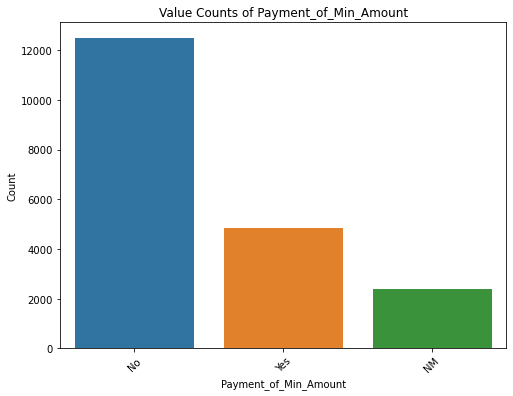

In [217]:
for column in X_train_obj.columns:
    plt.figure(figsize=(8, 6))
    
    # Get value counts for the column
    value_counts = X_train_obj[column].value_counts()
    
    # Plotting the value counts
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f"Value Counts of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

#### One Hot encoding

In [218]:
columns = ['Payment_of_Min_Amount']

X_train_obj = pd.get_dummies(X_train_obj, columns=columns, drop_first = True)
X_val_obj = pd.get_dummies(X_val_obj, columns=columns, drop_first = True)

#### Label Encoding

In [219]:
le = LabelEncoder()
X_train_obj['Credit_Mix'] = le.fit_transform(X_train_obj.Credit_Mix)
X_val_obj['Credit_Mix'] = le.fit_transform(X_val_obj.Credit_Mix)
#X_train_obj['Payment_Behaviour'] = le.fit_transform(X_train_obj.Payment_Behaviour)
#X_val_obj['Payment_Behaviour'] = le.fit_transform(X_val_obj.Payment_Behaviour)

#### MinMax Scaler

In [220]:
scaler = MinMaxScaler()

X_train_num_standardized = pd.DataFrame(scaler.fit_transform(X_train_num), 
                                        columns=X_train_num.columns, index=X_train_num.index)
X_val_num_standardized = pd.DataFrame(scaler.transform(X_val_num), 
                                      columns=X_val_num.columns, index=X_val_num.index)

X_train_num_standardized.head()

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
22103,0.283397,0.278038,0.555556,0.750,0.631579,0.0,0.628571,0.782609,0.422391,0.384615,0.528565,0.357412,0.690058,0.000000,0.115828,0.408702
15650,0.255571,0.287938,0.888889,0.875,0.578947,1.0,0.314286,0.217391,0.446679,0.076923,0.115802,0.293223,0.798246,0.023835,0.117491,0.240367
6557,0.201418,0.196250,0.111111,0.375,0.000000,0.0,0.285714,0.260870,0.275142,0.153846,0.410165,0.670291,0.461988,0.000000,0.131665,0.414636
12841,0.073984,0.084250,0.888889,0.750,0.736842,0.0,0.485714,0.739130,0.409488,0.538462,0.180638,0.323455,0.561404,0.000000,0.055606,0.293549
18979,0.646024,0.640064,0.888889,0.375,0.315789,1.0,0.428571,0.434783,0.039469,0.076923,0.498104,0.490514,0.535088,0.048255,0.317280,0.240102


In [221]:
X_train = pd.concat([X_train_num_standardized, X_train_obj], axis = 1)
X_val = pd.concat([X_val_num_standardized, X_val_obj], axis = 1)

#### Feature selection by mutual information

Text(0, 0.5, 'Mutual Information')

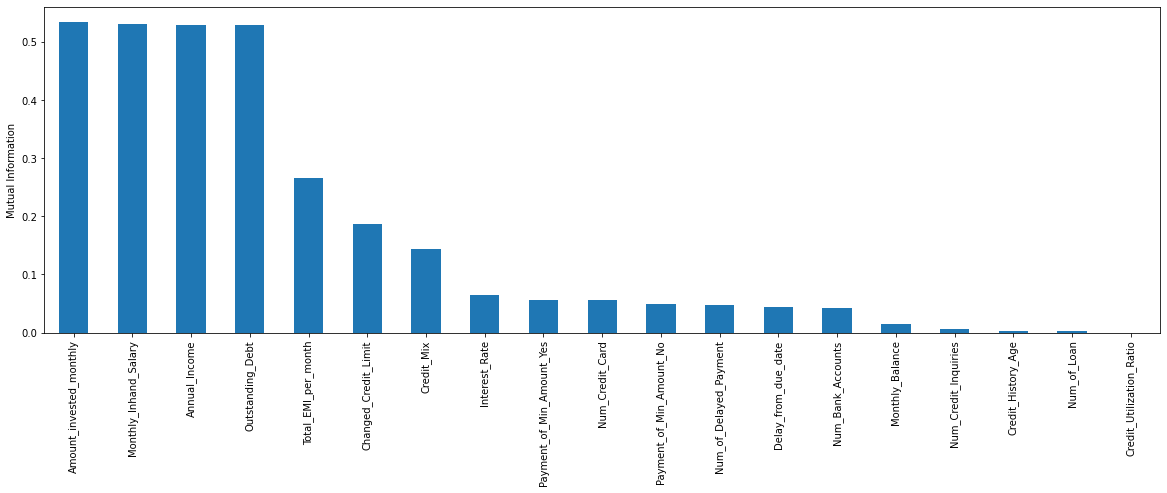

In [222]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [223]:
sel = SelectKBest(mutual_info_classif, k=14).fit(X_train, y_train)
X_train.columns[sel.get_support()]
X_train_1 = sel.transform(X_train)
X_val_1 = sel.transform(X_val)
X_train = pd.DataFrame(X_train_1, columns = X_train.columns[sel.get_support()] )
X_val = pd.DataFrame(X_val_1, columns = X_val.columns[sel.get_support()] )


## Train a ML Model and additionally hyperparameter tuning


In [243]:
def best_boosting_model(X_train, y_train, X_val, y_val):
    models = {
        'LightGBM': LGBMClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'XGBoost': XGBClassifier(),
        'CatBoost': CatBoostClassifier(verbose=False),
    }
    
    train_scores = {}
    val_scores = {}
    
    best_model_name = None
    best_val_recall = 0.0
    best_model = None  # Variable to store the best model
    
    for model_name, model in models.items():
        if model_name == 'CatBoost':
            model.fit(X_train, y_train, verbose=False)
        else:
            model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
        train_precision = precision_score(y_train, y_train_pred, average='weighted')
        train_recall = recall_score(y_train, y_train_pred, average='weighted')
        
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted')
        val_recall = recall_score(y_val, y_val_pred, average='weighted')
        
        train_scores[model_name] = (train_accuracy, train_f1, train_precision, train_recall)
        val_scores[model_name] = (val_accuracy, val_f1, val_precision, val_recall)
        
        print(f'{model_name}:')
        print(f'Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}\n')
        
        # Compute the confusion matrix
        conf = confusion_matrix(y_val, y_val_pred)
        
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('Actual Labels')
        plt.show()
        
        # Perform hyperparameter tuning
        if model_name == 'LightGBM':
            param_grid = {'num_leaves': [25, 35, 50], 'learning_rate': [0.05, 0.01], 'reg_alpha': [0.1, 0.5, 0.8]}
            grid_search = GridSearchCV(model, param_grid, scoring='f1_weighted', cv=3)
            grid_search.fit(X_train, y_train)
            
            best_params = grid_search.best_params_
            model.set_params(**best_params)
            
            print(f'Best Parameters - {model_name}: {best_params}\n')
        
        elif model_name == 'XGBoost':
            param_grid = {'max_depth': [3, 5, 7, 9], 'learning_rate': [0.1, 0.05, 0.01], 'reg_alpha': [0.1, 0.5, 1]}
            grid_search = GridSearchCV(model, param_grid, scoring='f1_weighted', cv=3)
            grid_search.fit(X_train, y_train)
            
            best_params = grid_search.best_params_
            model.set_params(**best_params)
            
            print(f'Best Parameters - {model_name}: {best_params}\n')
        
        # Compare validation recall
        if val_recall > best_val_recall:
            best_model_name = model_name
            best_val_recall = val_recall
            best_model = model 
    
    print(f'Best Model: {best_model_name}, Best Validation Recall: {best_val_recall:.4f}')
        
    return train_scores, val_scores, best_model

LightGBM:
Train Accuracy: 0.8386, Train F1 Score: 0.8371, Train Precision: 0.8388, Train Recall: 0.8386
Validation Accuracy: 0.8135, Validation F1 Score: 0.8123, Validation Precision: 0.8120, Validation Recall: 0.8135



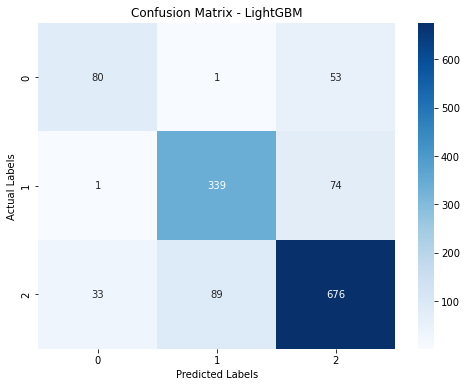

Best Parameters - LightGBM: {'learning_rate': 0.05, 'num_leaves': 50, 'reg_alpha': 0.5}

Gradient Boosting:
Train Accuracy: 0.7469, Train F1 Score: 0.7368, Train Precision: 0.7458, Train Recall: 0.7469
Validation Accuracy: 0.7452, Validation F1 Score: 0.7372, Validation Precision: 0.7392, Validation Recall: 0.7452



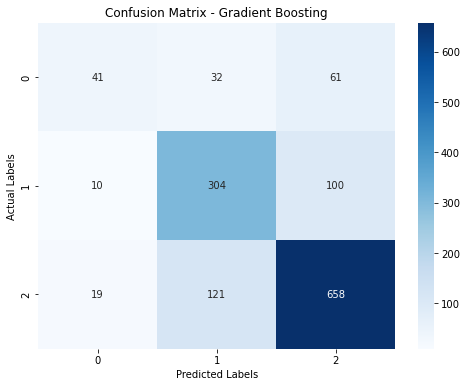

AdaBoost:
Train Accuracy: 0.6883, Train F1 Score: 0.6696, Train Precision: 0.6766, Train Recall: 0.6883
Validation Accuracy: 0.6954, Validation F1 Score: 0.6795, Validation Precision: 0.6799, Validation Recall: 0.6954



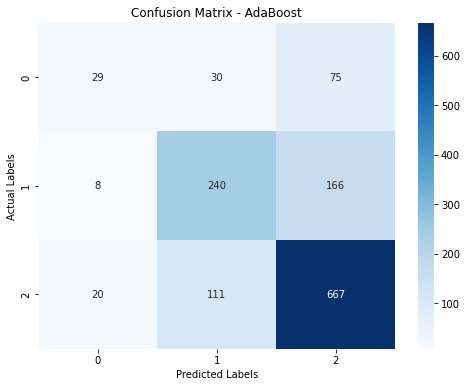

XGBoost:
Train Accuracy: 0.8661, Train F1 Score: 0.8654, Train Precision: 0.8661, Train Recall: 0.8661
Validation Accuracy: 0.8143, Validation F1 Score: 0.8143, Validation Precision: 0.8145, Validation Recall: 0.8143



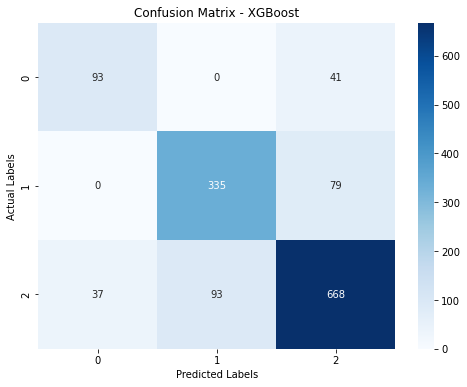

Best Parameters - XGBoost: {'learning_rate': 0.1, 'max_depth': 9, 'reg_alpha': 0.5}

CatBoost:
Train Accuracy: 0.8549, Train F1 Score: 0.8535, Train Precision: 0.8546, Train Recall: 0.8549
Validation Accuracy: 0.8039, Validation F1 Score: 0.8029, Validation Precision: 0.8025, Validation Recall: 0.8039



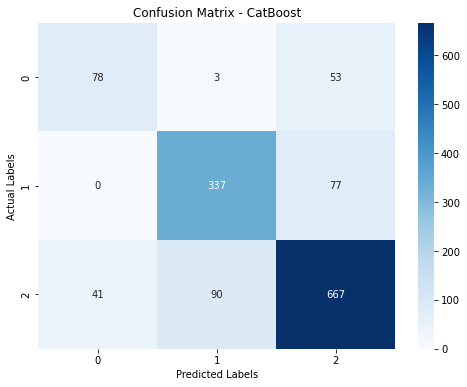

Best Model: XGBoost, Best Validation Recall: 0.8143


In [244]:
train_scores, val_scores, best_model = best_boosting_model(X_train, y_train, X_val, y_val)

In [245]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

# Evaluate the model using at least one benchmark

In [251]:
def evaluate(best_model, X, y):
    random_baseline = DummyClassifier(strategy='uniform')
    random_baseline.fit(X, y)
    random_predictions = random_baseline.predict(X)
    
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X, y)
    logistic_regression_predictions = logistic_regression.predict(X)
    
    print('logistic_regression')
    print('Accuracy:', accuracy_score(y, logistic_regression_predictions))
    print('Precision:', precision_score(y, logistic_regression_predictions, average='weighted'))
    print('Recall:', recall_score(y, logistic_regression_predictions, average='weighted'))
    print('F1 Score:', f1_score(y, logistic_regression_predictions, average='weighted'))
    print()

    
    print('Logistic Regression Evaluation')
    print('Accuracy:', accuracy_score(y, random_predictions))
    print('Precision:', precision_score(y, random_predictions, average='weighted'))
    print('Recall:', recall_score(y, random_predictions, average='weighted'))
    print('F1 Score:', f1_score(y, random_predictions, average='weighted'))
    print()
    
    print('Best Model:')
    best_predictions = best_model.predict(X)
    print('Accuracy:', accuracy_score(y, best_predictions))
    print('Precision:', precision_score(y, best_predictions, average='weighted'))
    print('Recall:', recall_score(y, best_predictions, average='weighted'))
    print('F1 Score:', f1_score(y, best_predictions, average='weighted'))

In [253]:
evaluate(best_model, X_val, y_val)


logistic_regression
Accuracy: 0.7154531946508172
Precision: 0.7236160418072984
Recall: 0.7154531946508172
F1 Score: 0.7008131511920038

Logistic Regression Evaluation
Accuracy: 0.3098068350668648
Precision: 0.4462013894419563
Recall: 0.3098068350668648
F1 Score: 0.344050481015225

Best Model:
Accuracy: 0.8142644873699851
Precision: 0.814547363964867
Recall: 0.8142644873699851
F1 Score: 0.8143022833359836
